In [98]:
#%% Load Modules
#startup_file='init_python.py'
#exec(open(startup_file).read())
#from matplotlib.patches import Rectangle

import numpy as np
from matplotlib import pyplot as plt


# Universal Functions

In [99]:
# DEFINE SPECTRUM FITTING FUNCTIONS

# full Rayleigh-Jeans
def RayleighJeans_function(x,a):
    return 1.0/( (x/a) + 1.0)

# Rayleigh-Jeans right front
def RayleighJeans_function(x,a):
    return a/x

# constant fit
def constant_function(x,a):
    return a



In [100]:
# CONVERT FROM K TO OMEGA REPRESENTATION

def convert_k_to_omega(k,n_k):

    n_omega = n_k[1:]/(2.0*k[1:]) 	# n_1d/2k = n_omega 1d sepctrum in freq space
    omega = k[1:]**2	
    
    return omega, n_omega

In [101]:
# ESTIMATE MU AND T
def estimate_mu_T(omega,n_omega):
    
	# constant fit at low omega = T/mu = normValue
 
	normValue, pcov = curve_fit(constant_function, omega[klow_min:klow_max], n_omega[klow_min:klow_max])
 
	##normalisationValue = np.max(n_omega[0:(3*kf//4)])				#Simon's computation of nomralisationValue =  maxValue
	##normalisationValue = np.mean(n_omega[0:kmax_low])			#Alternative computation of nomralisationValue =  meanValue
	

	# this is T estimate from Rayleigh-Jeans fit	
	T, pcov = curve_fit(constant_function, omega[khigh_min:khigh_max], omega[khigh_min:khigh_max] *n_omega[khigh_min:khigh_max])
	
	mu = T / normValue
    
	return mu, T

In [113]:
# ESTIMATE MU AND T
def estimate_mu_T_log(omega,n_omega, omega_plus):
    
	# constant fit at low omega = T/mu = normValue
 
	normValue, pcov = curve_fit(constant_function, omega[klow_min:klow_max], n_omega[klow_min:klow_max])
 
	##normalisationValue = np.max(n_omega[0:(3*kf//4)])				#Simon's computation of nomralisationValue =  maxValue
	##normalisationValue = np.mean(n_omega[0:kmax_low])			#Alternative computation of nomralisationValue =  meanValue
	

	# this is T estimate from log-corrected fit	
	T, pcov = curve_fit(constant_function, omega[khigh_min:khigh_max], np.log(omega[khigh_min:khigh_max]/(omega_plus+0.01))**(-1.0/3.0)*omega[khigh_min:khigh_max] *n_omega[khigh_min:khigh_max])
	
	mu = T / normValue
    
	return mu, T

In [103]:
def find_omega_plus(x, y):  # x = omega, y = n_omega
    threshold = 1.e-8
   
    i = len(y)-1           # end index of y array
    #val = x[i]*y[i]              # record value. should be close to zero
    val = y[i]
    while val < threshold:
        i = i - 1           # go through array backwards
        #val = x[i]*y[i]
        val = y[i]
        if i==0:
            val=1
    return x[i]                    # once value goes over threshold, return the value of eta at index


def find_eta_plus(x, y):  # x = eta, y = eta * phi
    threshold = 1.e-8
    i = len(y)-1           # end index of y array
    val = y[i]              # record value. should be close to zero
    while val < threshold:
        i = i - 1           # go through array backwards
        val = y[i]
       
        if i==0:
            val=1
    return eta[i]                    # once value goes over threshold, return the value of eta at index


# FREE DYNAMICS

In [104]:
# DEFINE PARAMETERS FROM SIMULATION 

N_ensemble = 1    #number of ensembles created for freely evoling sumilations. Used for averaging data

file_start = 1  #define the start/end files for plotting
file_end = 450

dt = 0.01  #time between files (OLD: 0.5 factor due to change in equation). Simulation time = dt * filenumber

#initial injection scale in k- and freq-space
kf = 32
wf = kf**2.0


L = 2.0*np.pi   #box size
N = 1024        #number of spatial grid points in data

#fluxes defined from initial forcing
wave_action_flux = 2.0 * 32.12
energy_flux = 2.0 * 8.41969e6

#fit regions for T/mu
klow_min = 0
klow_max = 6

#fit regions for T/\omega
khigh_min = 32
khigh_max = 100

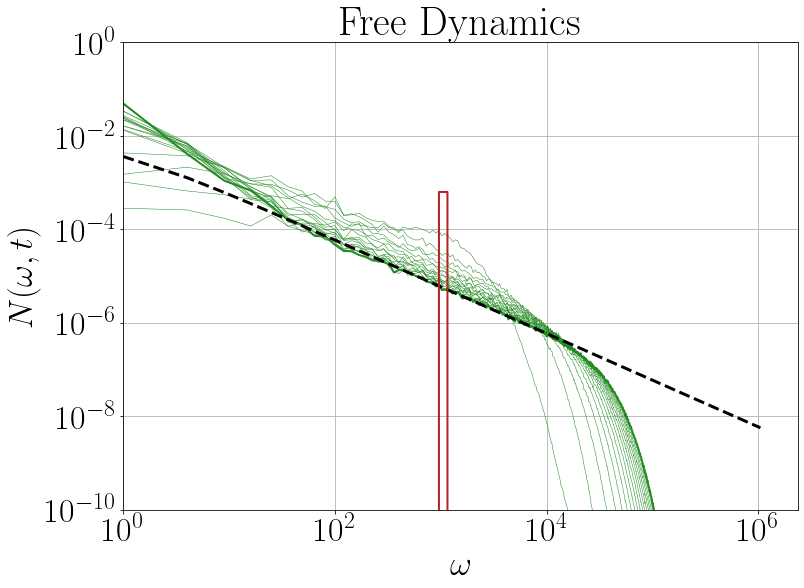

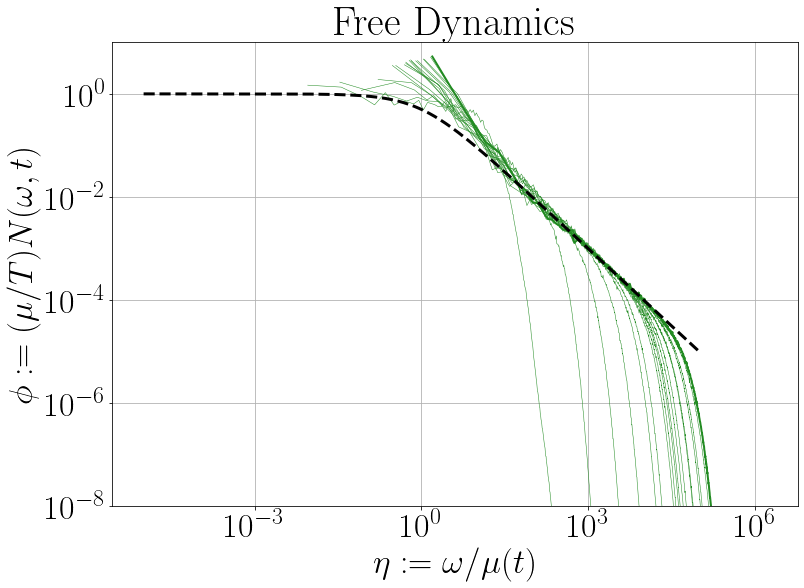

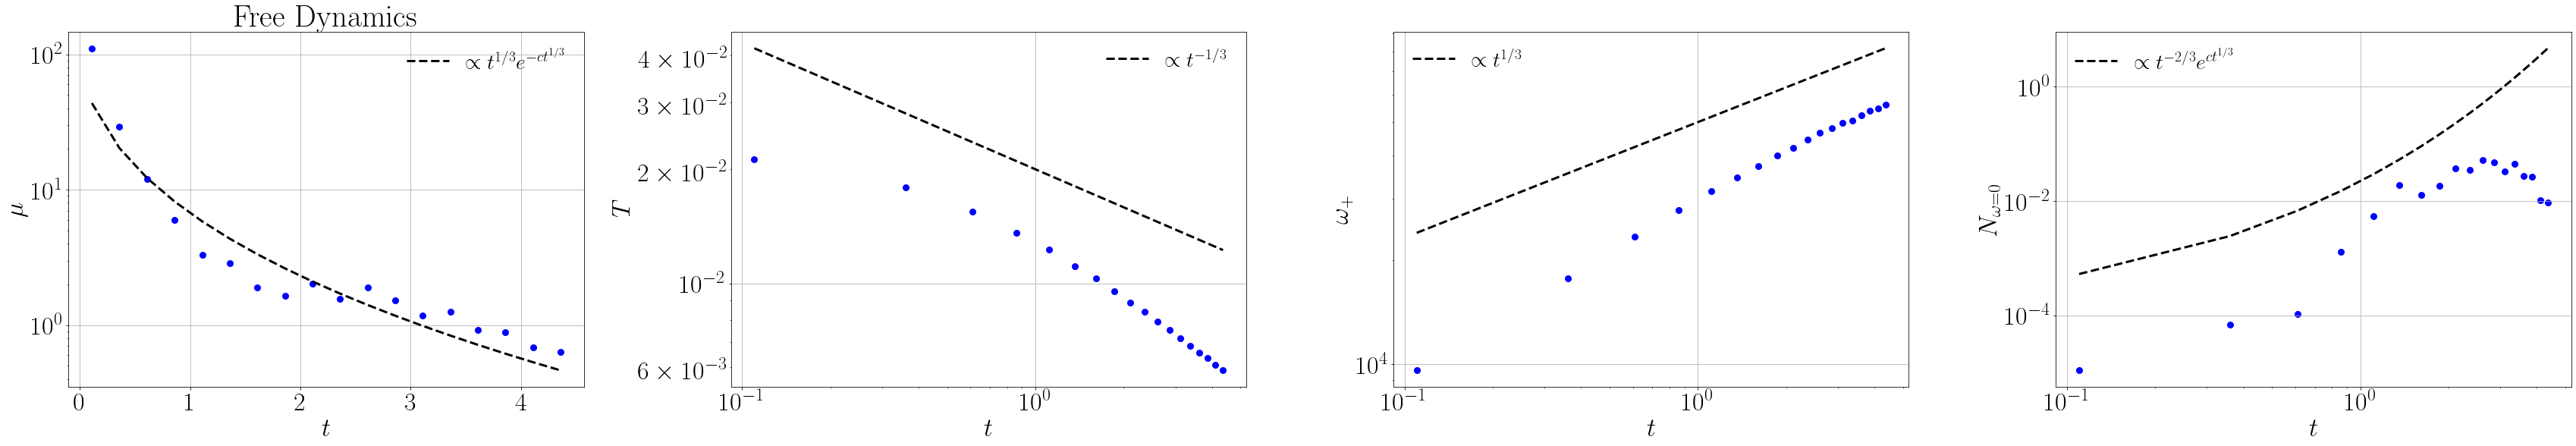

In [105]:

#DECALRE DATA ARRAYS FOR ANALYSIS

n_k = np.zeros(N)
temp = np.zeros(file_end-file_start+1)
mu =  np.zeros(file_end-file_start+1)
time = np.zeros(file_end-file_start+1)
omega_plus = np.zeros(file_end-file_start+1)


time_data = []
mu_data = []
temp_data = []
omega_plus_data = []
condensate_data = []


fig1, axs1 = newfig(1, 1)

fig2, axs2 = newfig(1, 1)

fig3, axs3 = newfig(1, 4)

for file_num in range(file_start+10,file_end+1,25):	#loop over data, every 25 files

	time = file_num * dt		# define simulation time
 
	time_data.append(time)
 
	n_k = 0.0
	
	#average over ensembles
	#for ensemble_num in range(1,N_ensemble,1):
	#	filename = '/data2/2d_gp_selfsimilar/decay_at_512_ensemble_%.1d/output/spectrum.%.5d' % (ensemble_num,file_num);
	#	data = np.loadtxt(filename)
	#	n_k += data[:,1]

	#n_k /= N_ensemble   # this is the 2d spectrum  
	#k = data[:,0]		


	filename = '/data/2d_gross_pitaevskii/selfsimilar/TEST_Free_N=1024_kf=32_a=1p5e-1/output/spectrum.%.6d' % (file_num);    
	data = np.loadtxt(filename)
	
	n_k = data[:,1] 
	k = data[:,0]		

	omega, n_omega = convert_k_to_omega(k,n_k)


	if file_num == file_start:			# compute total energy and wave action from initial file
		total_wave_action = np.sum(n_k)
		total_energy = 0.5 * np.sum(k * k * n_k)

	#calculate omega_plus
	omega_plus = find_omega_plus(omega, n_omega)

	omega_plus_data.append(omega_plus)

	#calculate mu and temp
	mu, temp = estimate_mu_T(omega, n_omega)

	mu_data.append(mu)
	temp_data.append(temp)
	condensate_data.append(n_k[0])

	

	##eta = omega * time**(- 1.0 / 3.0)
	##phi = n_omega * time**( 2.0 / 3.0)
	eta = omega /mu
	phi = n_omega * mu / temp

	axs1.plot(omega, n_omega, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    						# plots the wave action spectrum (not rescaled)					
	
	axs2.plot(eta, phi, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the re-scaled wave action spectrum
	
axs1.plot(omega, n_omega, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))										# plots the wave action spectrum (not rescaled)	

axs2.plot(eta, phi, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))							# plots the re-scaled wave action spectrum

	
Gibbs = (temp/mu) / (1.0 + (omega/mu))																							# define theoretical Gibbs solution
axs1.plot(omega[:], Gibbs[:],linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')									# plots the theoretical gibbs solution on wave action spectrum


initial=0.0*omega
initial[kf-2:kf+2]=0.0001*2*np.pi
axs1.plot(omega, initial, linewidth=2,c='firebrick')																			# plot the initial spectrum on wave action spectrum


#axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs1.annotate(text='$t=0$',xy=(wf-120000,1e-3),c='firebrick')
axs1.grid()
axs1.set_xlabel(r'$\omega$')
axs1.set_ylabel(r'$N(\omega,t)$')
axs1.set_yscale('log')
axs1.set_xscale('log')
axs1.set_xlim(1,(1024*1.5)**2)
axs1.set_ylim(1.e-10,1.e0)
#axs1.legend(loc='best', ncol=2)
axs1.set_title('Free Dynamics')
fig1.tight_layout()

fig1.savefig('spectrum_decay.pdf')


##################################################################################################################
eta = np.arange(1.e-5,1.e5,0.01)
Gibbs_fit = 1.0 / (eta+1.0)
axs2.plot(eta, Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')

#Extrap_fit = 1.0 / (eta*np.log(omega_plus/(mu*eta))**-0.33+1.0)
#axs2.plot(eta, Extrap_fit,linewidth=3,label=r'$Extrap$', color='red', linestyle='--')

#axs2.annotate(text=r'Anomalous Gibbs: $\frac{1}{\eta+1}$',xy=(1.1e-5,2.e0),c='k')
#axs2.annotate(text='$\leftarrow f_0$',xy=(wf,1e-4),c='firebrick')
axs2.grid()
axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs2.set_ylabel(r'$\phi:=(\mu/T)N(\omega,t)$')
axs2.set_yscale('log')
axs2.set_xscale('log')
#axs2.set_xlim(1e-5,1e4)
axs2.set_ylim(1.e-8,1.e1)
#axs1.legend(loc='best', ncol=2)

axs2.set_title('Free Dynamics')

fig2.tight_layout()

fig2.savefig('spectrum_scaled_decay.pdf')


##################################################################################################################

# plot mu vs t
axs3[0].scatter(time_data, mu_data,linewidth=3, color='b', linestyle='-')
c1= 1000.0  # fitting for c1* t^{1/3} * exp( -c2 * t^{1/3})
c2= 5.0
axs3[0].plot(time_data, c1*np.array(time_data)**(1.0/3.0) * np.exp(-c2* np.array(time_data)**(1.0/3.0)),linewidth=3,label=r'$\propto t^{1/3}e^{-c t^{1/3}}$', color='black', linestyle='--')


# plot for T vs t
axs3[1].scatter(time_data, temp_data,linewidth=3, color='b', linestyle='-')
c=2.e-2  # fitting for c* t^{-1/3}
axs3[1].plot(time_data, c*np.array(time_data)**(-1.0/3.0),linewidth=3,label=r'$\propto t^{-1/3}$', color='black', linestyle='--')

# plot for omega_+ vs t
axs3[2].scatter(time_data, omega_plus_data,linewidth=3, color='b', linestyle='-')
c= 5.e4		# fitting for c * t^{1/3}
axs3[2].plot(time_data, c*np.array(time_data)**(1.0/3.0),linewidth=3,label=r'$\propto t^{1/3}$', color='black', linestyle='--')


# plot N(omega =0)  vs t
axs3[3].scatter(time_data, condensate_data,linewidth=3, color='b', linestyle='-')
c1= 0.000001		# fitting for c * t^{-2/3} * Exp(c2 * t^{1/3})
c2= 10.0
axs3[3].plot(time_data, c1*np.array(time_data)**(-2.0/3.0)*np.exp(c2 * np.array(time_data)**(1.0/3.0)),linewidth=3,label=r'$\propto t^{-2/3}e^{c t^{1/3}}$', color='black', linestyle='--')


axs3[0].grid()
#axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs3[0].set_ylabel(r'$\mu$')
axs3[0].set_xlabel(r'$t$')
axs3[0].set_yscale('log')
axs3[0].legend(loc='best', ncol=2)

axs3[1].grid()
axs3[1].set_ylabel(r'$T$')
axs3[1].set_xlabel(r'$t$')
axs3[1].set_xscale('log')
axs3[1].set_yscale('log')
axs3[1].legend(loc='best', ncol=2)


axs3[2].grid()
axs3[2].set_ylabel(r'$\omega_+$')
axs3[2].set_xlabel(r'$t$')
axs3[2].set_xscale('log')
axs3[2].set_yscale('log')
#axs3[2].set_xlim(1e-2,1e0)
#axs3[2].set_ylim(1.e5,1.e6)
axs3[2].legend(loc='best', ncol=2)

axs3[0].set_title('Free Dynamics')

axs3[3].grid()
axs3[3].set_ylabel(r'$N_{\omega=0}$')
axs3[3].set_xlabel(r'$t$')
axs3[3].set_xscale('log')
axs3[3].set_yscale('log')
#axs3[3].set_xlim(1e-2,1e0)
#axs3[3].set_ylim(1.e5,1.e6)
axs3[3].legend(loc='best', ncol=2)

fig3.tight_layout()

fig3.savefig('parameters_decay.pdf')


# Forced Dynamics

In [106]:
# DEFINE EXTRAPOLATION FUNCTION
def Extrap_function(x,a):
    return 1.0/( (x/a)*np.log(omega_p/x)**-0.33 + 1.0)

In [107]:
# DEFINE PARAMETERS FROM SIMULATION 

N_ensemble = 1    #number of ensembles created for freely evoling sumilations. Used for averaging data

file_start = 1  #define the start/end files for plotting
file_end = 450

dt = 0.01  #time between files (OLD: 0.5 factor due to change in equation). Simulation time = dt * filenumber

#initial injection scale in k- and freq-space
kf = 32
wf = kf**2.0


L = 2.0*np.pi   #box size
N = 1024        #number of spatial grid points in data

#fluxes defined from initial forcing
wave_action_flux = 2.0 * 32.12
energy_flux = 2.0 * 8.41969e6

#fit regions for T/mu
klow_min = 0
klow_max = 6

#fit regions for T/\omega
khigh_min = 32
khigh_max = 100

## Rayleigh-Jeans fit

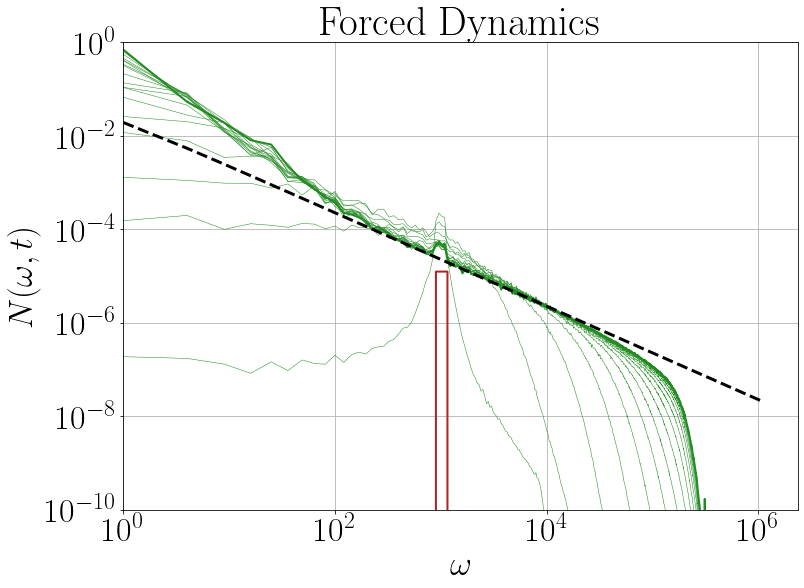

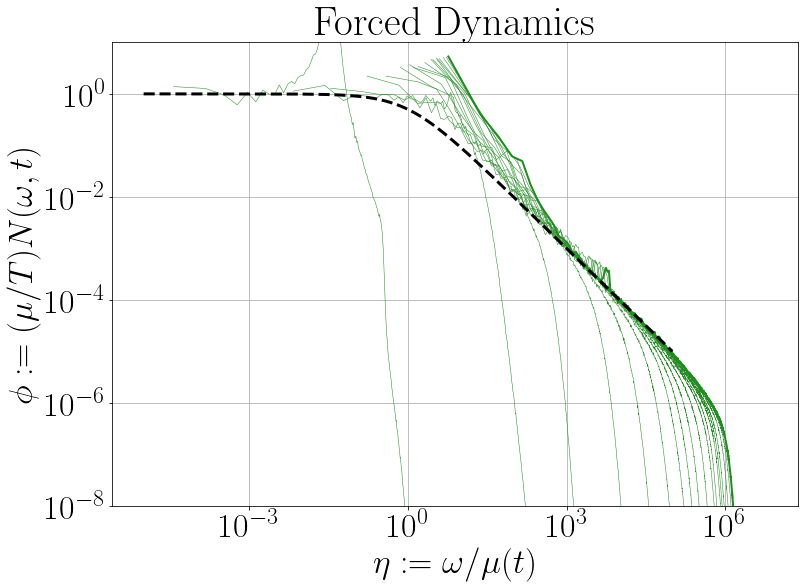

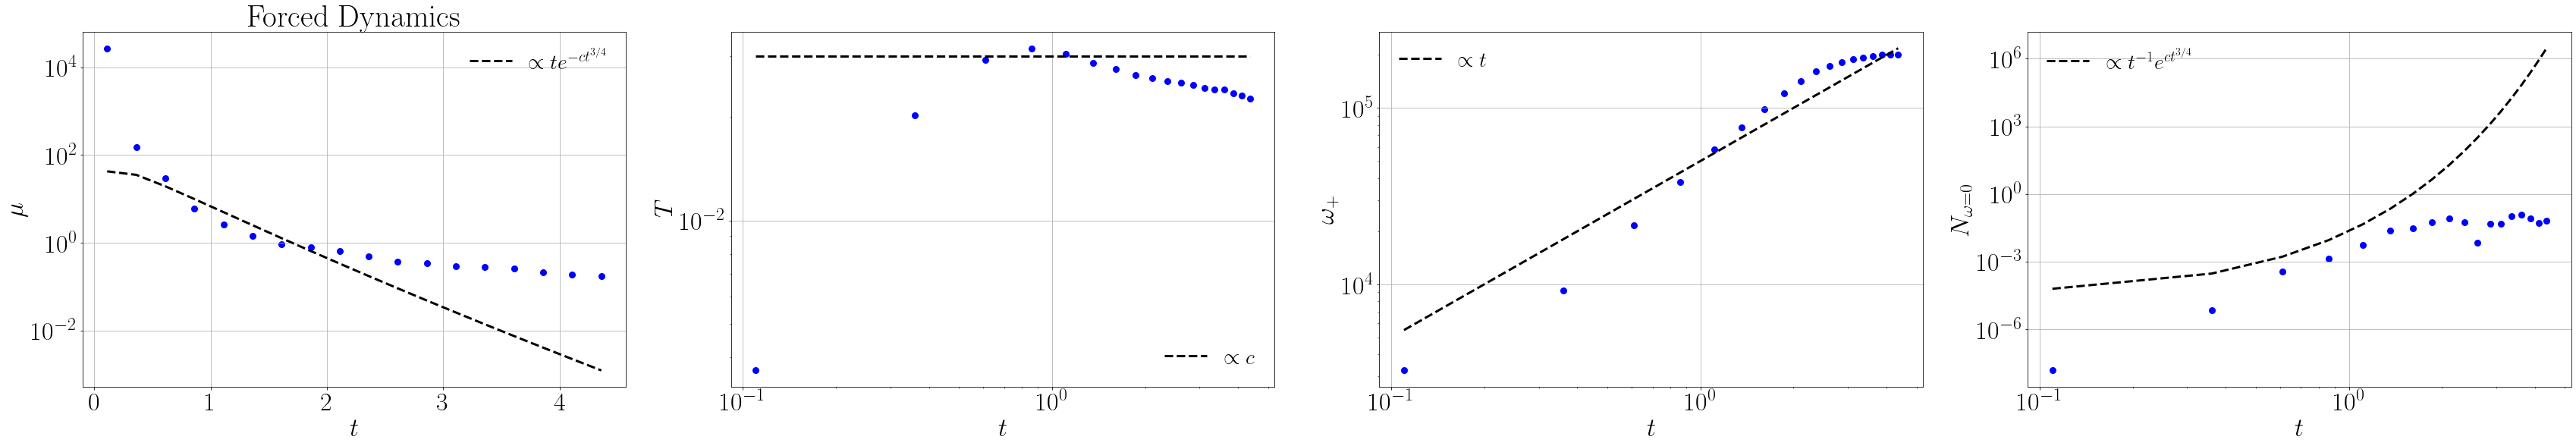

In [108]:

#DECALRE DATA ARRAYS FOR ANALYSIS

n_k = np.zeros(N)
temp = np.zeros(file_end-file_start+1)
mu =  np.zeros(file_end-file_start+1)
time = np.zeros(file_end-file_start+1)
omega_plus = np.zeros(file_end-file_start+1)


time_data = []
mu_data = []
temp_data = []
omega_plus_data = []
condensate_data = []


fig1, axs1 = newfig(1, 1)

fig2, axs2 = newfig(1, 1)

fig3, axs3 = newfig(1, 4)

for file_num in range(file_start+10,file_end+1,25):	#loop over data, every 25 files

	time = file_num * dt		# define simulation time
 
	time_data.append(time)
 
	n_k = 0.0
	
	#average over ensembles
	#for ensemble_num in range(1,N_ensemble,1):
	#	filename = '/data2/2d_gp_selfsimilar/decay_at_512_ensemble_%.1d/output/spectrum.%.5d' % (ensemble_num,file_num);
	#	data = np.loadtxt(filename)
	#	n_k += data[:,1]

	#n_k /= N_ensemble   # this is the 2d spectrum  
	#k = data[:,0]		


	filename = '/data/2d_gross_pitaevskii/selfsimilar/TEST_Forced_N=1024_kf=32_a=2p5e-2/output/spectrum.%.6d' % (file_num);    
	data = np.loadtxt(filename)
	
	n_k = data[:,1] 
	k = data[:,0]		

	omega, n_omega = convert_k_to_omega(k,n_k)


	if file_num == file_start:			# compute total energy and wave action from initial file
		total_wave_action = np.sum(n_k)
		total_energy = 0.5 * np.sum(k * k * n_k)

	#calculate omega_plus
	omega_plus = find_omega_plus(omega, n_omega)

	omega_plus_data.append(omega_plus)

	#calculate mu and temp
	mu, temp = estimate_mu_T(omega, n_omega)

	mu_data.append(mu)
	temp_data.append(temp)
	condensate_data.append(n_k[0])

	

	##eta = omega * time**(- 1.0 / 3.0)
	##phi = n_omega * time**( 2.0 / 3.0)
	eta = omega /mu
	phi = n_omega * mu / temp

	axs1.plot(omega, n_omega, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    						# plots the wave action spectrum (not rescaled)					
	
	axs2.plot(eta, phi, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the re-scaled wave action spectrum
	
axs1.plot(omega, n_omega, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))										# plots the wave action spectrum (not rescaled)	

axs2.plot(eta, phi, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))							# plots the re-scaled wave action spectrum

	
Gibbs = (temp/mu) / (1.0 + (omega/mu))																							# define theoretical Gibbs solution
axs1.plot(omega[:], Gibbs[:],linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')									# plots the theoretical gibbs solution on wave action spectrum


initial=0.0*omega
initial[kf-3:kf+2]=0.025**2  * (1.e-5)**0.5 *2*np.pi
axs1.plot(omega, initial, linewidth=2,c='firebrick')																			# plot the initial spectrum on wave action spectrum


#axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs1.annotate(text='$t=0$',xy=(wf-120000,1.e-3),c='firebrick')
axs1.grid()
axs1.set_xlabel(r'$\omega$')
axs1.set_ylabel(r'$N(\omega,t)$')
axs1.set_yscale('log')
axs1.set_xscale('log')
axs1.set_xlim(1,(1024*1.5)**2)
axs1.set_ylim(1.e-10,1.e0)
#axs1.legend(loc='best', ncol=2)
axs1.set_title('Forced Dynamics')
fig1.tight_layout()

fig1.savefig('spectrum_forced.pdf')


##################################################################################################################
eta = np.arange(1.e-5,1.e5,0.01)
Gibbs_fit = 1.0 / (eta+1.0)
axs2.plot(eta, Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')

#Extrap_fit = 1.0 / (eta*np.log(omega_plus/(mu*eta))**-0.33+1.0)
#axs2.plot(eta, Extrap_fit,linewidth=3,label=r'$Extrap$', color='red', linestyle='--')

#axs2.annotate(text=r'Anomalous Gibbs: $\frac{1}{\eta+1}$',xy=(1.1e-5,2.e0),c='k')
#axs2.annotate(text='$\leftarrow f_0$',xy=(wf,1e-4),c='firebrick')
axs2.grid()
axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs2.set_ylabel(r'$\phi:=(\mu/T)N(\omega,t)$')
axs2.set_yscale('log')
axs2.set_xscale('log')
#axs2.set_xlim(1e-5,1e4)
axs2.set_ylim(1.e-8,1.e1)
#axs1.legend(loc='best', ncol=2)

axs2.set_title('Forced Dynamics')

fig2.tight_layout()

fig2.savefig('spectrum_scaled_forced.pdf')


##################################################################################################################

# plot mu vs t
axs3[0].scatter(time_data, mu_data,linewidth=3, color='b', linestyle='-')
c1= 1000.0  # fitting for c1* t^{1} * exp( -c2 * t^{3/4})
c2= 5.0
axs3[0].plot(time_data, c1*np.array(time_data) * np.exp(-c2* np.array(time_data)**(3.0/4.0)),linewidth=3,label=r'$\propto te^{-c t^{3/4}}$', color='black', linestyle='--')


# plot for T vs t
axs3[1].scatter(time_data, temp_data,linewidth=3, color='b', linestyle='-')
c=3.e-2  # fitting for c* t^{0}
axs3[1].plot(time_data, c*np.array(time_data)/np.array(time_data),linewidth=3,label=r'$\propto c$', color='black', linestyle='--')

# plot for omega_+ vs t
axs3[2].scatter(time_data, omega_plus_data,linewidth=3, color='b', linestyle='-')
c= 5.e4		# fitting for c * t
axs3[2].plot(time_data, c*np.array(time_data),linewidth=3,label=r'$\propto t$', color='black', linestyle='--')


# plot N(omega =0)  vs t
axs3[3].scatter(time_data, condensate_data,linewidth=3, color='b', linestyle='-')
c1= 0.000001		# fitting for c * t^{-1} * Exp(c2 * t^{3/4})
c2= 10.0
axs3[3].plot(time_data, c1*np.array(time_data)**(-1.0)*np.exp(c2 * np.array(time_data)**(3.0/4.0)),linewidth=3,label=r'$\propto t^{-1}e^{c t^{3/4}}$', color='black', linestyle='--')


axs3[0].grid()
#axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs3[0].set_ylabel(r'$\mu$')
axs3[0].set_xlabel(r'$t$')
axs3[0].set_yscale('log')
axs3[0].legend(loc='best', ncol=2)

axs3[1].grid()
axs3[1].set_ylabel(r'$T$')
axs3[1].set_xlabel(r'$t$')
axs3[1].set_xscale('log')
axs3[1].set_yscale('log')
axs3[1].legend(loc='best', ncol=2)


axs3[2].grid()
axs3[2].set_ylabel(r'$\omega_+$')
axs3[2].set_xlabel(r'$t$')
axs3[2].set_xscale('log')
axs3[2].set_yscale('log')
#axs3[2].set_xlim(1e-2,1e0)
#axs3[2].set_ylim(1.e5,1.e6)
axs3[2].legend(loc='best', ncol=2)

axs3[0].set_title('Forced Dynamics')

axs3[3].grid()
axs3[3].set_ylabel(r'$N_{\omega=0}$')
axs3[3].set_xlabel(r'$t$')
axs3[3].set_xscale('log')
axs3[3].set_yscale('log')
#axs3[3].set_xlim(1e-2,1e0)
#axs3[3].set_ylim(1.e5,1.e6)
axs3[3].legend(loc='best', ncol=2)

fig3.tight_layout()

fig3.savefig('parameters_forced.pdf')


# log-corrected fit

/tmp/ipykernel_143860/169677872.py:86: RuntimeWarning: divide by zero encountered in power
  Extrap_fit = temp / (omega*np.log(omega_plus/omega)**-0.33+mu)
/tmp/ipykernel_143860/169677872.py:86: RuntimeWarning: invalid value encountered in power
  Extrap_fit = temp / (omega*np.log(omega_plus/omega)**-0.33+mu)


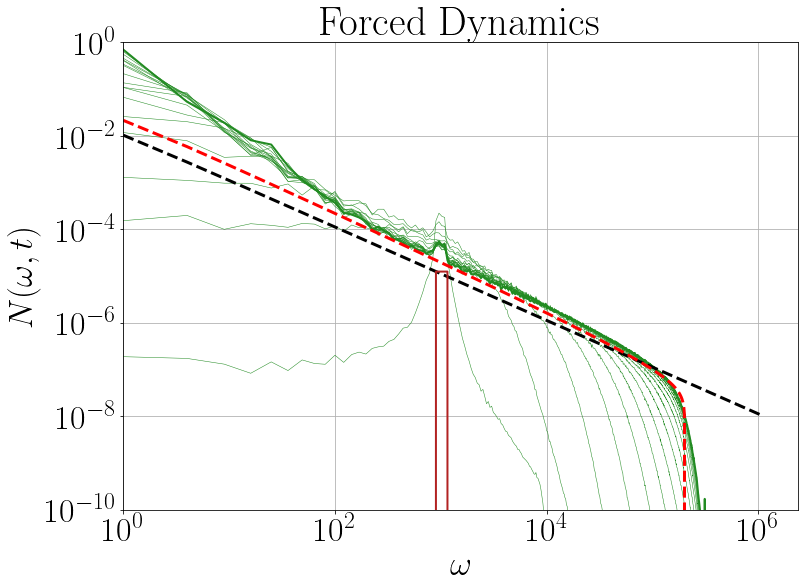

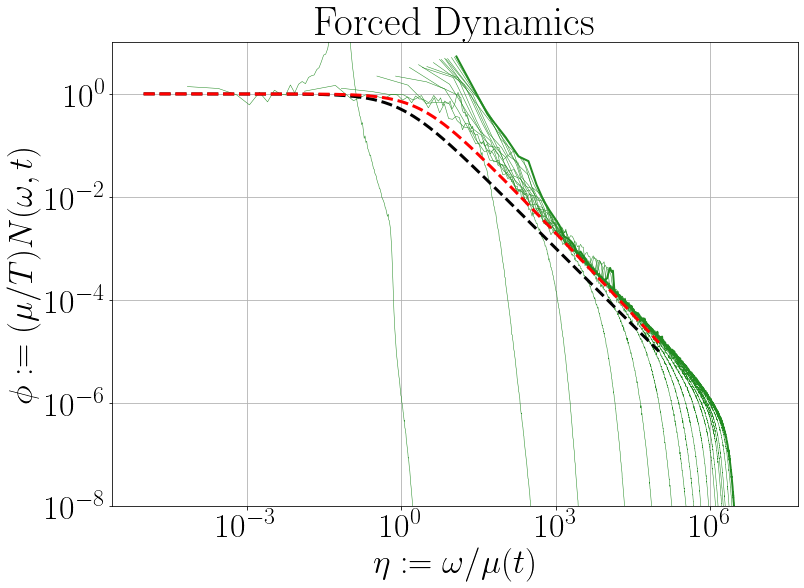

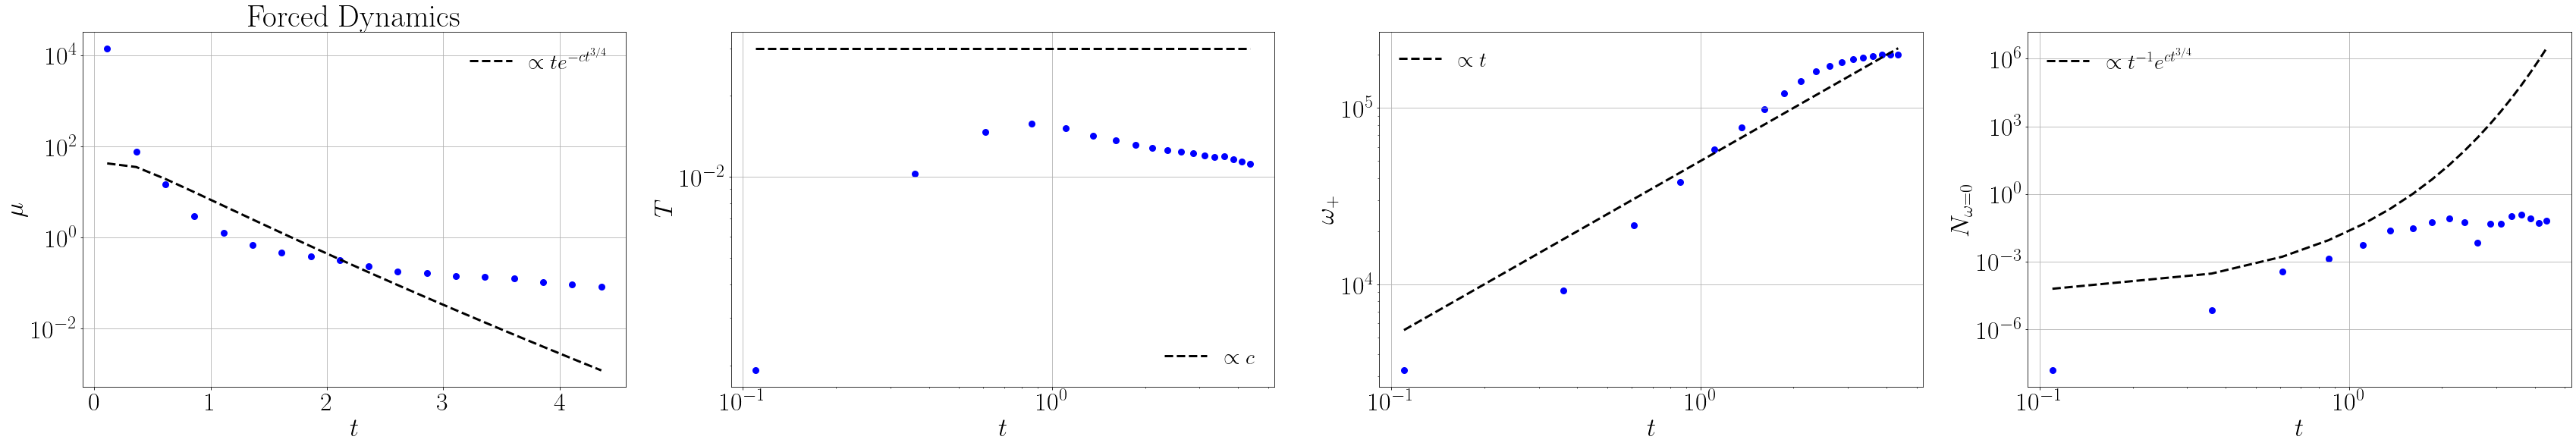

In [116]:

#DECALRE DATA ARRAYS FOR ANALYSIS

n_k = np.zeros(N)
temp = np.zeros(file_end-file_start+1)
mu =  np.zeros(file_end-file_start+1)
time = np.zeros(file_end-file_start+1)
omega_plus = np.zeros(file_end-file_start+1)


time_data = []
mu_data = []
temp_data = []
omega_plus_data = []
condensate_data = []


fig1, axs1 = newfig(1, 1)

fig2, axs2 = newfig(1, 1)

fig3, axs3 = newfig(1, 4)

for file_num in range(file_start+10,file_end+1,25):	#loop over data, every 25 files

	time = file_num * dt		# define simulation time
 
	time_data.append(time)
 
	n_k = 0.0
	
	#average over ensembles
	#for ensemble_num in range(1,N_ensemble,1):
	#	filename = '/data2/2d_gp_selfsimilar/decay_at_512_ensemble_%.1d/output/spectrum.%.5d' % (ensemble_num,file_num);
	#	data = np.loadtxt(filename)
	#	n_k += data[:,1]

	#n_k /= N_ensemble   # this is the 2d spectrum  
	#k = data[:,0]		


	filename = '/data/2d_gross_pitaevskii/selfsimilar/TEST_Forced_N=1024_kf=32_a=2p5e-2/output/spectrum.%.6d' % (file_num);    
	data = np.loadtxt(filename)
	
	n_k = data[:,1] 
	k = data[:,0]		

	omega, n_omega = convert_k_to_omega(k,n_k)


	if file_num == file_start:			# compute total energy and wave action from initial file
		total_wave_action = np.sum(n_k)
		total_energy = 0.5 * np.sum(k * k * n_k)

	#calculate omega_plus
	omega_plus = find_omega_plus(omega, n_omega)

	omega_plus_data.append(omega_plus)

	#calculate mu and temp
	mu, temp = estimate_mu_T_log(omega, n_omega,omega_plus)

	mu_data.append(mu)
	temp_data.append(temp)
	condensate_data.append(n_k[0])

	

	##eta = omega * time**(- 1.0 / 3.0)
	##phi = n_omega * time**( 2.0 / 3.0)
	eta = omega /mu
	phi = n_omega * mu / temp

	axs1.plot(omega, n_omega, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    						# plots the wave action spectrum (not rescaled)					
	
	axs2.plot(eta, phi, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the re-scaled wave action spectrum
	
axs1.plot(omega, n_omega, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))										# plots the wave action spectrum (not rescaled)	

axs2.plot(eta, phi, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))							# plots the re-scaled wave action spectrum

	
Gibbs = (temp/mu) / (1.0 + (omega/mu))																							# define theoretical Gibbs solution
axs1.plot(omega[:], Gibbs[:],linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')									# plots the theoretical gibbs solution on wave action spectrum


Extrap_fit = temp / (omega*np.log(omega_plus/omega)**-0.33+mu)
axs1.plot(omega[:], Extrap_fit[:],linewidth=3,label=r'$Extrap$', color='red', linestyle='--')									# plots the theoretical gibbs solution on wave action spectrum


initial=0.0*omega
initial[kf-3:kf+2]=0.025**2  * (1.e-5)**0.5 *2*np.pi
axs1.plot(omega, initial, linewidth=2,c='firebrick')																			# plot the initial spectrum on wave action spectrum


#axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs1.annotate(text='$t=0$',xy=(wf-120000,1.e-3),c='firebrick')
axs1.grid()
axs1.set_xlabel(r'$\omega$')
axs1.set_ylabel(r'$N(\omega,t)$')
axs1.set_yscale('log')
axs1.set_xscale('log')
axs1.set_xlim(1,(1024*1.5)**2)
axs1.set_ylim(1.e-10,1.e0)
#axs1.legend(loc='best', ncol=2)
axs1.set_title('Forced Dynamics')
fig1.tight_layout()

fig1.savefig('spectrum_forced.pdf')


##################################################################################################################
eta = np.arange(1.e-5,1.e5,0.01)
Gibbs_fit = 1.0 / (eta+1.0)
axs2.plot(eta, Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')

Extrap_fit = 1.0 / (eta*np.log(omega_plus/(mu*eta))**-0.33+1.0)
axs2.plot(eta, Extrap_fit,linewidth=3,label=r'$Extrap$', color='red', linestyle='--')

#axs2.annotate(text=r'Anomalous Gibbs: $\frac{1}{\eta+1}$',xy=(1.1e-5,2.e0),c='k')
#axs2.annotate(text='$\leftarrow f_0$',xy=(wf,1e-4),c='firebrick')
axs2.grid()
axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs2.set_ylabel(r'$\phi:=(\mu/T)N(\omega,t)$')
axs2.set_yscale('log')
axs2.set_xscale('log')
#axs2.set_xlim(1e-5,1e4)
axs2.set_ylim(1.e-8,1.e1)
#axs1.legend(loc='best', ncol=2)

axs2.set_title('Forced Dynamics')

fig2.tight_layout()

fig2.savefig('spectrum_scaled_forced.pdf')


##################################################################################################################

# plot mu vs t
axs3[0].scatter(time_data, mu_data,linewidth=3, color='b', linestyle='-')
c1= 1000.0  # fitting for c1* t^{1} * exp( -c2 * t^{3/4})
c2= 5.0
axs3[0].plot(time_data, c1*np.array(time_data) * np.exp(-c2* np.array(time_data)**(3.0/4.0)),linewidth=3,label=r'$\propto te^{-c t^{3/4}}$', color='black', linestyle='--')


# plot for T vs t
axs3[1].scatter(time_data, temp_data,linewidth=3, color='b', linestyle='-')
c=3.e-2  # fitting for c* t^{0}
axs3[1].plot(time_data, c*np.array(time_data)/np.array(time_data),linewidth=3,label=r'$\propto c$', color='black', linestyle='--')

# plot for omega_+ vs t
axs3[2].scatter(time_data, omega_plus_data,linewidth=3, color='b', linestyle='-')
c= 5.e4		# fitting for c * t
axs3[2].plot(time_data, c*np.array(time_data),linewidth=3,label=r'$\propto t$', color='black', linestyle='--')


# plot N(omega =0)  vs t
axs3[3].scatter(time_data, condensate_data,linewidth=3, color='b', linestyle='-')
c1= 0.000001		# fitting for c * t^{-1} * Exp(c2 * t^{3/4})
c2= 10.0
axs3[3].plot(time_data, c1*np.array(time_data)**(-1.0)*np.exp(c2 * np.array(time_data)**(3.0/4.0)),linewidth=3,label=r'$\propto t^{-1}e^{c t^{3/4}}$', color='black', linestyle='--')


axs3[0].grid()
#axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs3[0].set_ylabel(r'$\mu$')
axs3[0].set_xlabel(r'$t$')
axs3[0].set_yscale('log')
axs3[0].legend(loc='best', ncol=2)

axs3[1].grid()
axs3[1].set_ylabel(r'$T$')
axs3[1].set_xlabel(r'$t$')
axs3[1].set_xscale('log')
axs3[1].set_yscale('log')
axs3[1].legend(loc='best', ncol=2)


axs3[2].grid()
axs3[2].set_ylabel(r'$\omega_+$')
axs3[2].set_xlabel(r'$t$')
axs3[2].set_xscale('log')
axs3[2].set_yscale('log')
#axs3[2].set_xlim(1e-2,1e0)
#axs3[2].set_ylim(1.e5,1.e6)
axs3[2].legend(loc='best', ncol=2)

axs3[0].set_title('Forced Dynamics')

axs3[3].grid()
axs3[3].set_ylabel(r'$N_{\omega=0}$')
axs3[3].set_xlabel(r'$t$')
axs3[3].set_xscale('log')
axs3[3].set_yscale('log')
#axs3[3].set_xlim(1e-2,1e0)
#axs3[3].set_ylim(1.e5,1.e6)
axs3[3].legend(loc='best', ncol=2)

fig3.tight_layout()

fig3.savefig('parameters_forced.pdf')


In [ ]:

def estimate_mu_T_Extrap(omega,n_omega):
    
	# normalisationValue = T/\mu
	##normalisationValue = np.max(n_omega[0:(3*kf//4)])				#Simon's computation of nomralisationValue =  maxValue
	normalisationValue = np.mean(n_omega[0:kmax_low])			#Alternative computation of nomralisationValue =  meanValue
	
	kp = int(np.sqrt(omega_p))
 
	omega_fit = omega[0:kp]
	n_fit = n_omega[0:kp] / normalisationValue
	
 	
	mu_est, pcov = curve_fit(Extrap_function, omega_fit, n_fit)

	T = mu_est * normalisationValue
	mu = mu_est
    
	return mu, T

OSError: /data3/2d_gp_selfsimilar_direct/ensemble_0/output/spectrum.000020 not found.

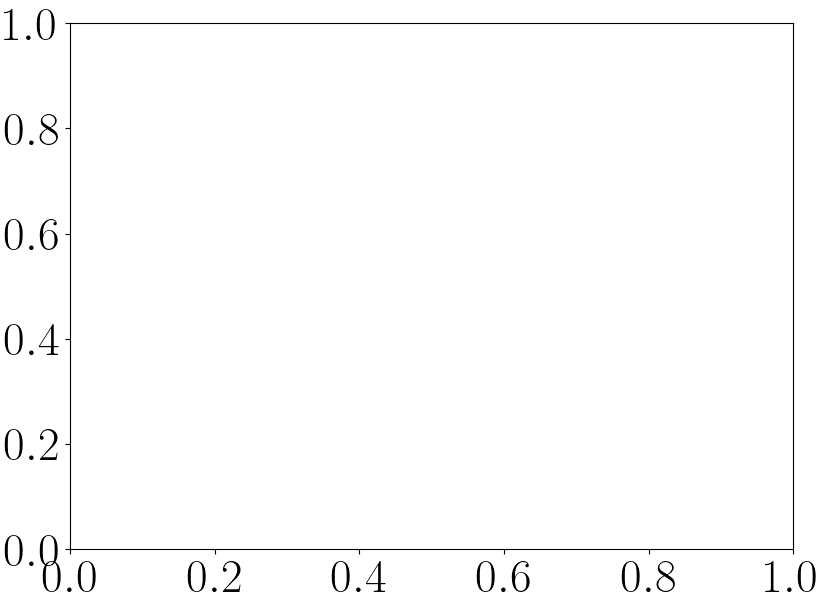

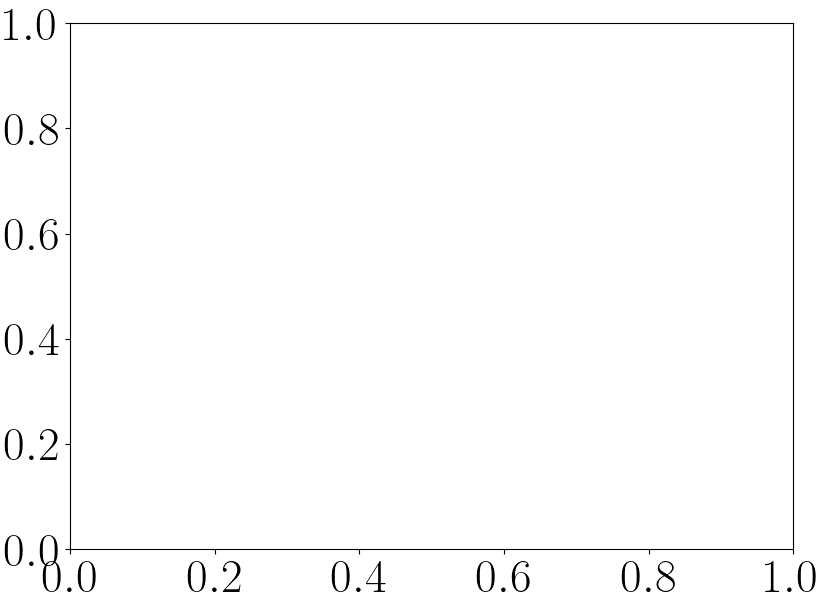

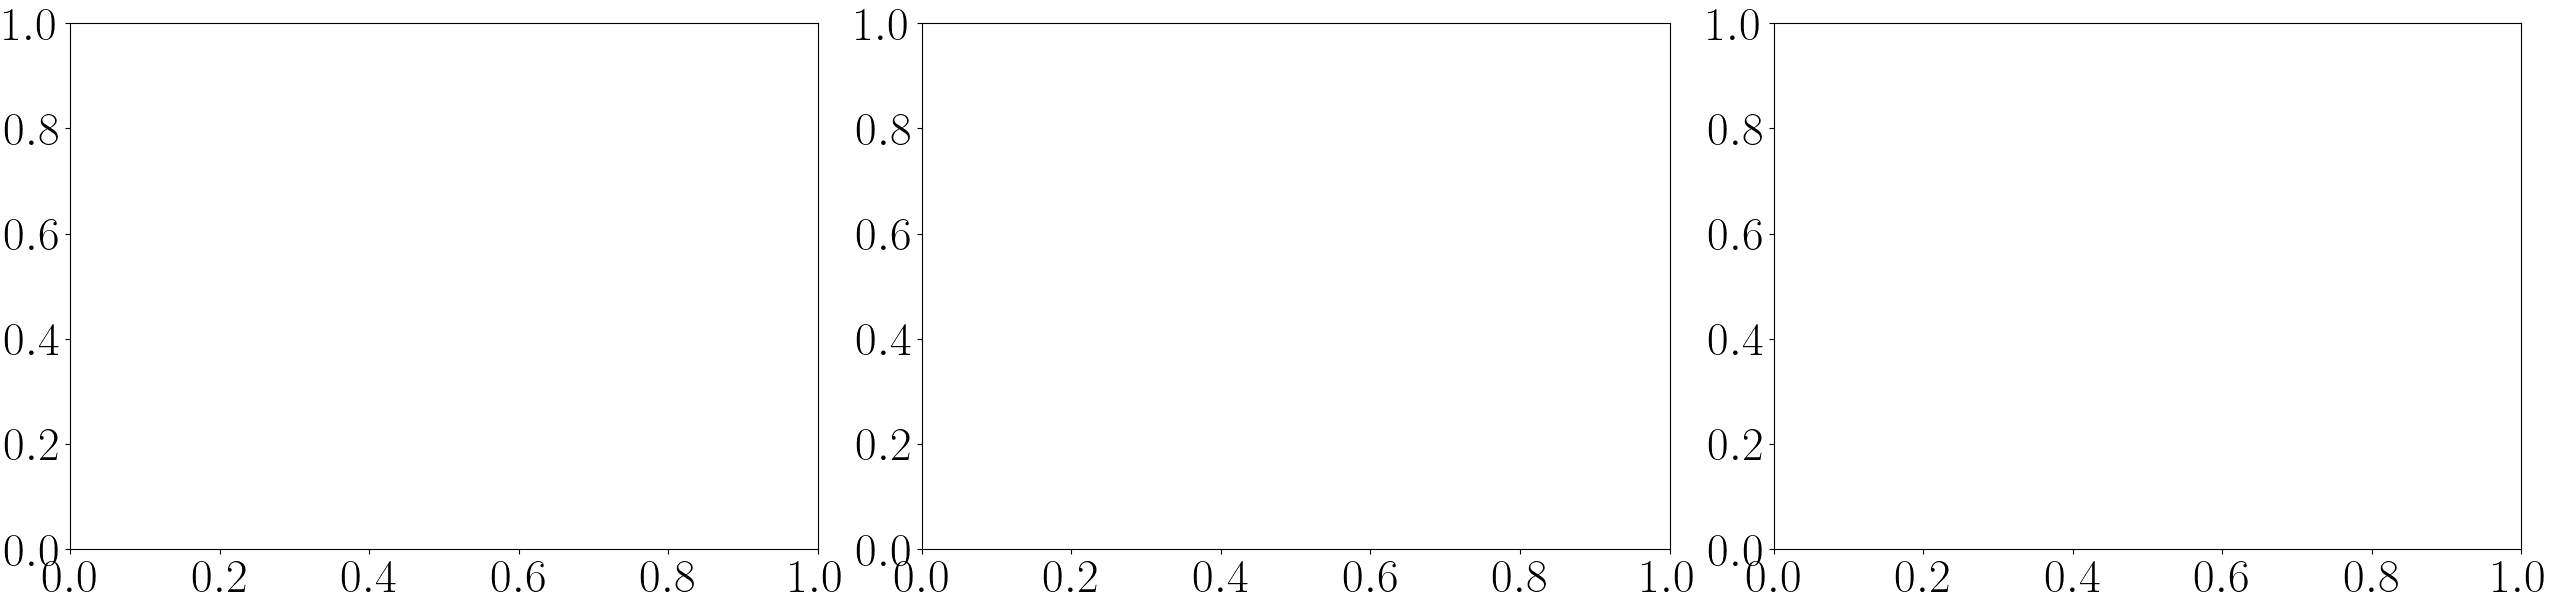

In [ ]:
# DEFINE PARAMETERS FROM SIMULATION 

N_ensemble = 3    #number of ensembles created for freely evoling sumilations. Used for averaging data

file_start = 10  #define the start/end files for plotting
file_end = 190

dt = 0.0005  #time between files (OLD: 0.5 factor due to change in equation). Simulation time = dt * filenumber

#initial injection scale in k- and freq-space
kf = 16
wf = kf**2.0


L = 2.0*np.pi   #box size
N = 2048        #number of spatial grid points in data

#fluxes defined from initial forcing
wave_action_flux = 2.0 * 32.12
energy_flux = 2.0 * 8.41969e6

#fit regions for T/mu
kmin_low = 1
kmax_low = 1

#fit regions for T/\omega
kmin_high = 2.e1
kmax_high = 2.e2

#DECALRE DATA ARRAYS FOR ANALYSIS

n_k = np.zeros(N)
temp = np.zeros(file_end-file_start+1)
mu =  np.zeros(file_end-file_start+1)
time = np.zeros(file_end-file_start+1)
omega_plus = np.zeros(file_end-file_start+1)


time_data = []
mu_data = []
temp_data = []
omega_plus_data = []


fig1, axs1 = newfig(1, 1)

fig2, axs2 = newfig(1, 1)

fig3, axs3 = newfig(1, 3)

for file_num in range(file_start+10,file_end+1,20):	#loop over data, every 25 files

	time = file_num * dt		# define simulation time
 
	time_data.append(time)
 
	n_k = 0.0
	


	#average over ensembles
	for ensemble_num in range(0,N_ensemble,1):
		#sfilename = '/data2/2d_gp_selfsimilar/ensemble_%.1d/output/spectrum.%.5d' % (ensemble_num,file_num);
		filename = '/data3/2d_gp_selfsimilar_direct/ensemble_%.1d/output/spectrum.%.6d' % (ensemble_num,file_num);
		data = np.loadtxt(filename)
		n_k += data[:,1]

	n_k /= N_ensemble   # this is the 2d spectrum  
	k = data[:,0]		

	#filename = '/Users/lauriej/Dropbox/output/spectrum.%.6d' % (file_num);    
	#data = np.loadtxt(filename)
	
	#n_k = data[:,1] 
	#k = data[:,0]		

	omega, n_omega = convert_k_to_omega(k,n_k)


	if file_num == file_start:			# compute total energy and wave action from initial file
		total_wave_action = np.sum(n_k)
		total_energy = 0.5 * np.sum(k * k * n_k)

	#calculate omega_plus
	omega_plus = find_omega_plus(omega, n_omega)

	omega_plus_data.append(omega_plus)

	#calculate mu and temp
	omega_p = find_omega_plus(omega, n_omega)	
	mu, temp = estimate_mu_T_Extrap(omega, n_omega)

	mu_data.append(mu)
	temp_data.append(temp)

	

	##eta = omega * time**(- 1.0 / 3.0)
	##phi = n_omega * time**( 2.0 / 3.0)
	eta = omega /mu
	phi = n_omega * mu / temp

	axs1.plot(omega, n_omega, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))    						# plots the wave action spectrum (not rescaled)					
	
	axs2.plot(eta, phi, linewidth=0.5,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))					# plots the re-scaled wave action spectrum
	
axs1.plot(omega, n_omega, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))										# plots the wave action spectrum (not rescaled)	

axs2.plot(eta, phi, linewidth=2,c='forestgreen',label=r't=%.3f' % round(dt*file_num,4))							# plots the re-scaled wave action spectrum

	
Gibbs = (temp/mu) / (1.0 + (omega/mu))	
Extrap = (temp/mu) / (1.0 + (omega/mu)*np.log(omega_plus/omega)**-0.33)	# define theoretical Gibbs solution
axs1.plot(omega[:], Extrap[:],linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')									# plots the theoretical gibbs solution on wave action spectrum


initial=0.0*omega
initial[kf-2:kf+2]=0.0001*2*np.pi
axs1.plot(omega, initial, linewidth=2,c='firebrick')																			# plot the initial spectrum on wave action spectrum


axs1.annotate(text=r'Gibbs',xy=(1.1,2.e-2),c='k')
axs1.annotate(text='$t=0$',xy=(wf-120000,1e-3),c='firebrick')
axs1.grid()
axs1.set_xlabel(r'$\omega$')
axs1.set_ylabel(r'$N(\omega,t)$')
axs1.set_yscale('log')
axs1.set_xscale('log')
axs1.set_xlim(1,(1024*1.5)**2)
axs1.set_ylim(1.e-10,1.e0)
#axs1.legend(loc='best', ncol=2)
axs1.set_title('Free Dynamics')
fig1.tight_layout()

fig1.savefig('spectrum_decay.pdf')


##################################################################################################################
eta = np.arange(1.e-5,1.e5,0.01)
Gibbs_fit = 1.0 / (eta+1.0)
axs2.plot(eta, Gibbs_fit,linewidth=3,label=r'$Gibbs$', color='black', linestyle='--')

Extrap_fit = 1.0 / (eta*np.log(omega_plus/(mu*eta))**-0.33+1.0)
axs2.plot(eta, Extrap_fit,linewidth=3,label=r'$Gibbs$', color='red', linestyle='--')

axs2.annotate(text=r'Anomalous Gibbs: $\frac{1}{\eta+1}$',xy=(1.1e-5,2.e0),c='k')
#axs2.annotate(text='$\leftarrow f_0$',xy=(wf,1e-4),c='firebrick')
axs2.grid()
axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs2.set_ylabel(r'$\phi:=(\mu/T)N(\omega,t)$')
axs2.set_yscale('log')
axs2.set_xscale('log')
#axs2.set_xlim(1e-5,1e4)
axs2.set_ylim(1.e-8,1.e1)
#axs1.legend(loc='best', ncol=2)

axs2.set_title('Free Dynamics')

fig2.tight_layout()

fig2.savefig('gibbs_decay.pdf')


##################################################################################################################

axs3[0].scatter(time_data, mu_data,linewidth=3,label=r'$Gibbs$', color='b', linestyle='-')
#axs3[0].plot(time_data, 1.e-1*np.array(time_data)**(1.0/3.0)*np.exp(-1000.0*np.array(time_data)**(1.0/3.0)),linewidth=3,label=r'$\propto t^{-1/3}$', color='black', linestyle='--')


axs3[1].scatter(time_data, temp_data,linewidth=3,label=r'$Gibbs$', color='b', linestyle='-')
#axs3[1].plot(time_data, 1.e-1*np.array(time_data)**(-1.0/3.0),linewidth=3,label=r'$\propto t^{-1/3}$', color='black', linestyle='--')


axs3[2].scatter(time_data, omega_plus_data,linewidth=3,label=r'$Gibbs$', color='b', linestyle='-')
axs3[2].plot(time_data, 1.e6*np.array(time_data),linewidth=3,label=r'$\propto t^{1/3}$', color='black', linestyle='--')

axs3[0].grid()
#axs2.set_xlabel(r'$\eta:=\omega/\mu(t)$')
axs3[0].set_ylabel(r'$\mu$')
axs3[0].set_xlabel(r'$t$')
axs3[0].set_yscale('log')

axs3[1].set_ylabel(r'$T$')
axs3[1].set_xlabel(r'$t$')
axs3[1].set_xscale('log')
axs3[1].set_yscale('log')

axs3[2].set_ylabel(r'$\omega_+$')
axs3[2].set_xlabel(r'$t$')
axs3[2].set_xscale('log')
axs3[2].set_yscale('log')
#axs3[2].set_xlim(1e-2,1e0)
#axs3[2].set_ylim(1.e5,1.e6)
#axs1.legend(loc='best', ncol=2)

#axs3.set_title('Free Dynamics')

fig3.tight_layout()

fig3.savefig('parameters.pdf')

